# Where is the demand for IT infrastructure ?

Use the "Run" button to execute the code.

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="my-web-scraping")

### <font color='#E913D1'>IT startups would want to work in countries with active demand for IT services. In this notebook we are webscraping a reputed global tender information website **https://www.tendersinfo.com** for collecting comprehensive data on which countries are spending on IT infrastructure</font>

![](https://i.imgur.com/2aBph8H.jpg)

### TODO:
### 1. _access tender information web portal_
### 2. _cycle through the web pages and  collect the html data_
### 3. *use Beautiful Soup library to collect tender information tabular data*
### 4. *construct a pandas dataframe to collate the data*
### 5. *create a csv file for the tabular data*

### Output:

###  we will generate a csv having Name of country, tender date, item description, due date

## <font color='green'>**Summary of Input and Output**</font> 

![img](https://i.imgur.com/SR9fhxa.jpg)

### Import the libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time 
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual,Layout
from tqdm.notebook import tnrange,tqdm

### _we have used requests library to access the webpages_ 
### (https://docs.python-requests.org/en/master/)
### _we have used BeautifulSoup library to parse the webpages_ 
### (https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
### _we have used Pandas library to tabulate the results_ 
### (https://pandas.pydata.org/)
### _we have used time module to control the request frequency_ 
### (https://docs.python.org/3/library/time.html#module-time)

### <font color='blue'>get the number of records of Infotech Tenders on the portal</font>

In [2]:
def get_item_num():
    try:
        html=requests.get('https://www.tendersinfo.com/global-information-technology-tenders.php').text
        soup=BeautifulSoup(html,"html.parser")
        number_of_items=soup.find_all('div',{'class':'col-lg-5'})[0].get_text().split()[0]
        print(f'The number of records are {int(number_of_items)}')
        print(f'please choose the number of records needed by using the slider')
        return int(number_of_items)
    except response.status_code !=200:
        print(f"wrong response {response.status_code}")
# gets the number of records
num_items=int(get_item_num())
# the widget slider object is initialized
style = {'description_width': 'initial'}
slider=widgets.IntSlider(value=0,min=0,max=num_items,step=1,description='Number of Records:',layout=Layout(width='900px'),style=style) 
# display the widget
display(slider)         

The number of records are 260281
please choose the number of records needed by using the slider


IntSlider(value=0, description='Number of Records:', layout=Layout(width='900px'), max=260281, style=SliderSty…

### <font color='blue'>display the number of records chosen</font>

In [3]:
# interactive widget having lambda function to return the value from the slider   
choose_records=interactive(lambda num: num,num=slider)
chosen_value=choose_records.children[0].value # capture the value selected by the slider
print(f'{chosen_value} records have been chosen')

20037 records have been chosen


### <font color='blue'>The Main function will call helper functions to download the data and create a tabular format</font>

#### <font color="red">**please initialize the helper functions before calling the main function**</font>

In [8]:
def main():
    """ main function which cycles through webpages and calls other function"""
    base_url="https://www.tendersinfo.com/global-information-technology-tenders-"
   
    df_tender=pd.DataFrame()
    len_records=0 
    start_time=time.time()   
    # maximum range cannot exceed the chosen value by the user
    while len_records<=chosen_value:
        for i in tnrange(chosen_value,desc="downloading",total=(chosen_value/1300),colour="blue"): # tnrange will set up the progress bar       
            # slow the querying of url
            time.sleep(2)        
            url=base_url+str(i)+".php"
            #print(url)
            mlist=get_master_list(url)
            df=pd.DataFrame(mlist)
            df_tender=pd.concat([df_tender,df],ignore_index=True,axis=0)  
            len_records=df_tender.shape[0]   # updation of records obtained
            if len_records>=chosen_value:
                break
    df_tender.columns=['Country','Start_date','Summary','Deadline']
    # format the date columns for time
    df_tender['Start_date']=pd.to_datetime(df_tender['Start_date'], format='%d-%b-%Y') # date parsed as datetime
    df_tender['Deadline']=pd.to_datetime(df_tender['Deadline'], format='%d-%b-%Y')
    current_time=time.time()
    print(f'the time taken is {round(current_time-start_time)} seconds')
    return df_tender
df_main=main()


the time taken is 87 seconds


### The helper functions

### <font color='blue'>function to get the url as a response object</font>

In [4]:
def get_url(url):
    """ function to get the response object"""
    #print('in get_url')
    try:
        response=requests.get(url)
        
        #print(f'response code is {response.status_code}')        
        return response
    except response.status_code !=200:
        print(f"wrong response {response.status_code}")

#### <font color='green'>output of the function</font>

In [5]:
output_get_url=get_url('https://www.tendersinfo.com/global-information-technology-tenders.php')
print(f'get_url creates the {type(output_get_url)} object')

response code is 200
get_url creates the <class 'requests.models.Response'> object


### <font color='blue'>function to create html file backup and extract html content</font>

In [5]:
def text_url(url):
    """ function to create a html file as backup and extract the html content"""
    #print('in text_url')
    page=get_url(url)
    with open('global-information-technology-tenders.html', 'a', encoding="utf-8") as file:
        file.write(page.text)        
    text=page.text
       
    #print(f'extract of page :{page.text[:70]}')
    return text

#### <font color='green'>output of the function</font>

In [14]:
output_text_url=text_url('https://www.tendersinfo.com/global-information-technology-tenders.php')
print(f'text_url creates the {type(output_text_url)} object')

extract of page :<style type="text/css">
	.img-responsive, .thumbnail>img, .thumbnail 
text_url creates the <class 'str'> object


### <font color='blue'>function to read in html as beautiful soup object and return the desired table rows</font>

In [6]:
def parse_text(url):
    """function to read in html as beautiful soup object and return the desired table rows"""
    
    page_content=text_url(url)
    #print(f'the length of the webpage is {len(page_content)}')
    soup=BeautifulSoup(page_content,'html.parser')
    soup_table=soup.find_all('table',{'id':"datatable",'class':'table table-striped table-bordered'})
    soup_row=soup_table[0].find_all('tr')
    #print('table extracted')
    return soup_row

#### <font color='green'>output of the function</font>

In [18]:
output_parse_text=parse_text('https://www.tendersinfo.com/global-information-technology-tenders.php')
print(f'parse_text creates the {type(output_parse_text)} object')

the length of the webpage is 306974
parse_text creates the <class 'bs4.element.ResultSet'> object


### <font color='blue'>function to extract table values and append to a dataframe</font>

In [7]:
def get_master_list(url):  
    """function to extract table values and append to a dataframe"""
    
    soup_row=parse_text(url)
    master_lst=[] 
    for item in soup_row:        
        for sibling in item.next_siblings:
            if hasattr(sibling,'bs4.element.NavigableString'):
                entry=sibling.find_all('td')
                entry_lst=[]
                for sub_item in entry:
                    entry_lst.append(sub_item.get_text().strip())
                master_lst.append(entry_lst)
    #print('listing done')       
    #print(master_lst[0])
    return master_lst  

#### <font color='green'>output of the function</font>

In [23]:
output_get_master_list=get_master_list('https://www.tendersinfo.com/global-information-technology-tenders.php')
print(f'get_master_list creates the {type(output_get_master_list)} object')

['United States', '20-Apr-2021', 'Data Entry Function-indexing Outsourcing.', '19-May-2021']
get_master_list creates the <class 'list'> object


## tender details compiled as dataframe

In [17]:
in_lst=['Info_tech' for i in range(df_main.shape[0])]
df_main['category']=pd.Series(in_lst)

In [18]:
df_main.head()

,Country,Start_date,Summary,Deadline,category
0,Spain,2021-04-20,Supply Of Migration And Updating Of Software L...,2021-05-07,Info_tech
1,Lithuania,2021-04-20,Qualified Remote Email Signature Hardware And ...,2021-05-03,Info_tech
2,Spain,2021-04-20,The Contract Object Is The Provision Of A Lice...,2021-05-04,Info_tech
3,Russian Federation,2021-04-20,Provision Of Services For The Modernization Of...,2021-04-29,Info_tech
4,United States,2021-04-20,Cisco Equipment.,2021-04-26,Info_tech


In [19]:
df_main.shape

(19600, 5)

## tender details written as csv file 

In [20]:
df_main.to_csv("info_tech_tenders.csv",index=None)

##  <font color='blue' >top 10 countries based on the number of tenders issued</font>         

<AxesSubplot:ylabel='Country'>

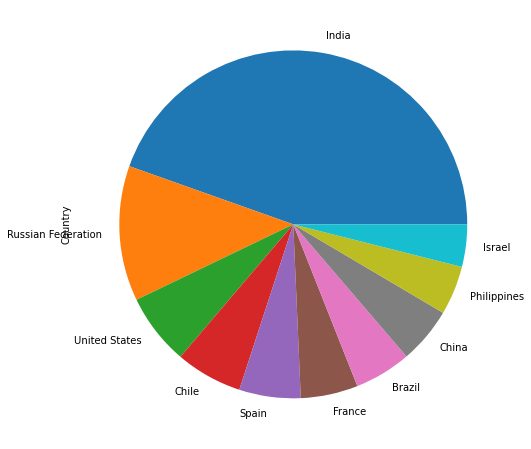

In [21]:
df_main.Country.value_counts()[:10].plot.pie(figsize=(8,8))

### References

### 1.https://jovian.ai/aakashns/python-web-scraping-project-guide 
### 2.https://jovian.ai/aakashns/python-web-scraping-project-guide 
### 3.https://realpython.com/python-web-scraping-practical-introduction/  
### 4.https://www.brookings.edu/research/trends-in-the-information-technology-sector/
    

### Libraries used

#### _we have used requests library to access the webpages_ 
#### (https://docs.python-requests.org/en/master/)
#### _we have used BeautifulSoup library to parse the webpages_ 
#### (https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
#### _we have used Pandas library to tabulate the results_ 
#### (https://pandas.pydata.org/)
#### _we have used time module to control the request frequency_ 
#### (https://docs.python.org/3/library/time.html#module-time)
#### _we have used ipywidgets module to create the slider tool and read data from it_ 
#### (https://ipywidgets.readthedocs.io/en/stable/)
#### _we have used tqdm module to create the progress bar_
#### (https://github.com/tqdm/tqdm)

### Future Work

### 1. create a general purpose web scraping tool to access data from several tender portals
### 2. carry out Exploratory Data Analysis to summarize and understand the data and find patterns